In [2]:
%cd ../
import utils
%cd "./Intermediate Leaderboard Submission"

from sklearn.neural_network import MLPClassifier
import pandas as pd
import pickle

c:\NUS\Year 4\Sem 1\DSA4266\teamedward
c:\NUS\Year 4\Sem 1\DSA4266\teamedward\Intermediate Leaderboard Submission


100%|██████████| 121838/121838 [00:00<00:00, 205596.21it/s]
c:\NUS\Year 4\Sem 1\DSA4266\teamedward\utils.py:202: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = len(row[3])
c:\NUS\Year 4\Sem 1\DSA4266\teamedward\utils.py:202: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = len(row[3])


Iteration 1, loss = 0.58667961
Iteration 2, loss = 0.51158927
Iteration 3, loss = 0.50550343
Iteration 4, loss = 0.50040545
Iteration 5, loss = 0.49747769
Iteration 6, loss = 0.49347615
Iteration 7, loss = 0.49042776
Iteration 8, loss = 0.48720050
Iteration 9, loss = 0.48433501
Iteration 10, loss = 0.48212831
Iteration 11, loss = 0.48013393
Iteration 12, loss = 0.47750021
Iteration 13, loss = 0.47677582
Iteration 14, loss = 0.47411822
Iteration 15, loss = 0.47434453
Iteration 16, loss = 0.47249385
Iteration 17, loss = 0.47167434
Iteration 18, loss = 0.47054142
Iteration 19, loss = 0.47103121
Iteration 20, loss = 0.46927056
Iteration 21, loss = 0.46877362
Iteration 22, loss = 0.46855599
Iteration 23, loss = 0.46758173
Iteration 24, loss = 0.46668488
Iteration 25, loss = 0.46735484
Iteration 26, loss = 0.46648482
Iteration 27, loss = 0.46561161
Iteration 28, loss = 0.46648624
Iteration 29, loss = 0.46590468
Iteration 30, loss = 0.46397244
Iteration 31, loss = 0.46362059
Iteration 32, los

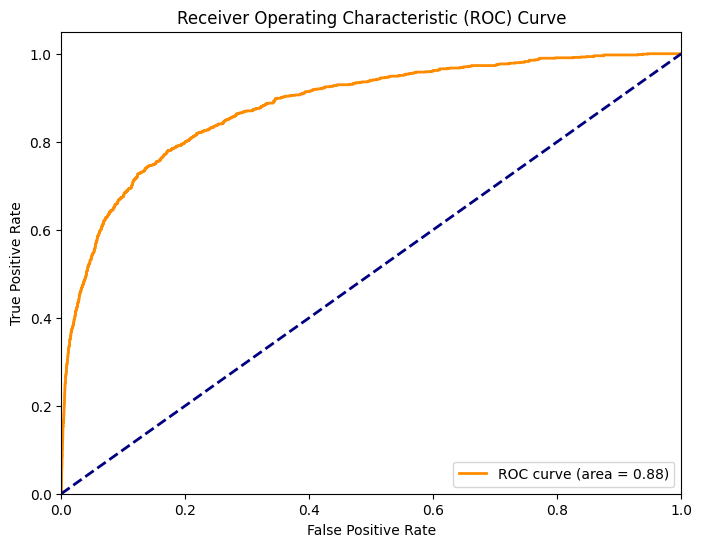

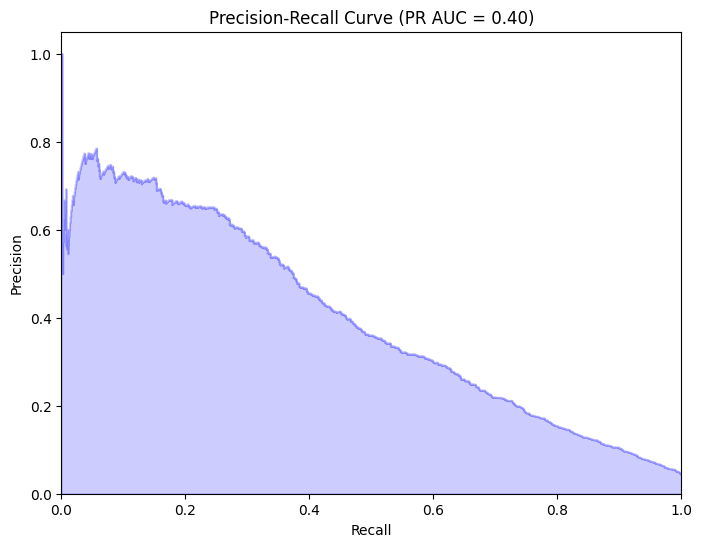

PR-AUC score : 0.3956864154161993
ROC-AUC score : 0.8812876024240756
Average of both scores : 0.6385


In [7]:
data_json_dir = "../data/dataset0.json"
data_info_dir = "../data/data.info"
output_dir ="../data/"
sklearn_model =  MLPClassifier(verbose = 2, hidden_layer_sizes=(16,16),learning_rate_init=0.001, activation="logistic", alpha  = 0.1)
who_mode = "zac"
prefit = False
processed = False

trained_model = utils.full_pipeline(data_json_dir, data_info_dir,output_dir,sklearn_model,who_mode,prefit,processed)

In [5]:
def save(model, filename):
    """
    Saved the model to the given filename as a pickle file

    Args:
        model: Trained model to be saved
        filename : file name where model is to be saved
    
    """
    pickle.dump(model, open(filename, "wb"))

In [10]:
save(sklearn_model, "../models/fitted_sklearnmlp.pkl")

In [3]:
with open("../models/fitted_sklearnmlp.pkl","rb") as file:
    sklmodel_loaded = pickle.load(file)

In [4]:
sklmodel_loaded

MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(16, 16),
              verbose=2)

In [5]:
import random
import numpy as np

def zac_generate_features(data_df, is_test, data_label_info=None):
    def calculate_mean(row):
        readings_array = np.array(row)
        return np.mean(readings_array, axis=0).tolist()

    min_length = 99999
    for idx, row in data_df.iterrows():
        length = len(row[3])
        if length < min_length:
            min_length = length

    if not is_test:
        data_df['transcript_position'] = data_df['transcript_position'].astype(int)
        full_data = data_df.merge(data_label_info, on = ['transcript_position','transcript_id'])
        positive_data = full_data[full_data['label']== 1]
        negative_data = full_data[full_data['label']== 0]
        random.seed(4266)
        ## Control sample size using n.  n <= 20
        n = min(15, min_length)
        row_list = []
        # create new positive data until we achieve 1:1 ratio of positive to nagatives
        while len(row_list) < len(negative_data):
        # sample a random row
            row = positive_data.sample(n=1)
            # sample n readings and create a new row for the new positive data
            sample_reads = random.sample(row['readings'].tolist()[0],n)
            t_id = row['transcript_id'].tolist()[0]
            t_pos = row['transcript_position'].tolist()[0]
            fmer = row['5-mers'].tolist()[0]
            gene_id = row['gene_id'].tolist()[0]
            label = row['label'].tolist()[0]
            row_dict = {'transcript_id':t_id, 'transcript_position':t_pos, '5-mers': fmer, 'readings':sample_reads, 'gene_id':gene_id, 'label':label}
            row_list.append(row_dict)

        new_positive_data = pd.DataFrame(row_list)

        df = pd.concat([new_positive_data, negative_data], ignore_index=True)
    else:
        df = data_df

    df['readings'] = df['readings'].apply(calculate_mean)

    # Split the "readings" column into separate columns
    split_readings = df['readings'].apply(lambda x: pd.Series(x))
    split_readings.columns = [f'value_{i}' for i in range(9)]

    # Concatenate the split columns with the original DataFrame
    df = pd.concat([df, split_readings], axis=1)
    # Drop readings
    df.drop(columns='readings',inplace = True)

    column_mapping = {
        'value_0': 'dwell_time_-1',
        'value_1': 'sd_-1',
        'value_2': 'mean_-1',
        'value_3': 'dwell_time_0',
        'value_4': 'sd_0',
        'value_5': 'mean_0',
        'value_6': 'dwell_time_1',
        'value_7': 'sd_1',
        'value_8': 'mean_1'
    }

    df = df.rename(columns=column_mapping)
    # Define the possible gene types
    gene_types = ['A', 'C', 'T', 'G']

    # Create a one-hot encoding for each position and gene type
    for position in range(7):
        for gene_type in gene_types:
            col_name = f'5-mer-{position}_{gene_type}'
            df[col_name] = (df['5-mers'].str[position] == gene_type).astype(int)  # Convert to 1 or 0

    # Drop the original useless positions
    columns_to_drop = ['5-mer-3_A', '5-mer-3_C', '5-mer-3_T', '5-mer-3_G',
                   '5-mer-4_A', '5-mer-4_C', '5-mer-4_T', '5-mer-4_G',
                   '5-mer-1_C', '5-mer-2_C', '5-mer-2_T', '5-mer-5_G',]

    # Drop the specified columns
    df = df.drop(columns=columns_to_drop)
    # rename 5-mers to  "five-mer" so that dropping in train_model has no error
    df = df.rename(columns={'5-mers': 'five_mer'})
    return df

In [6]:
intermediate_datasets = ["dataset0.json", "dataset1.json", "dataset2.json"]

In [8]:
data_dir = "../data"
output_dir ="../data/"

df_list = []

for dataset in intermediate_datasets:
    df = utils.process_json_data(f"{data_dir}/{dataset}", "old")
    processed_df = zac_generate_features(df, True)
    df_list.append(processed_df)

100%|██████████| 121838/121838 [00:00<00:00, 213644.56it/s]
C:\Users\Edward\AppData\Local\Temp\ipykernel_23812\463875044.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = len(row[3])
100%|██████████| 90810/90810 [00:00<00:00, 206646.23it/s]
C:\Users\Edward\AppData\Local\Temp\ipykernel_23812\463875044.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  length = len(row[3])
100%|██████████| 1323/1323 [00:00<00:00, 54669.51it/s]
C:\Users\Edward\AppData\Local\Temp\ipykernel_23812\463875044.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

In [10]:
scaler = False
model = sklmodel_loaded

for indx,df in enumerate(df_list):
    test_df_full = df.copy()
    test_df = test_df_full.drop(columns = ['transcript_id', 'transcript_position','five_mer'])
    
    if scaler:
        x_test = scaler.transform(test_df)
    try:
        y_pred_prob = model.predict_proba(test_df)
    except:
        y_pred_prob = model.predict(test_df)
    
    test_df_full["score"] = y_pred_prob[:,1]
    # Save to file
    test_df_full[["transcript_id","transcript_position","score"]].to_csv(f"./teamedward_dataset{indx}_1.csv", index=False)



Sanity Check

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [23]:
dataset0_labels = pd.read_csv('../data/data.info')
dataset0_predict = pd.read_csv('../Intermediate Leaderboard Submission/teamedward_dataset0_1.csv')
dataset0_merged = pd.merge(dataset0_labels,dataset0_predict, on = ['transcript_id','transcript_position'])

In [24]:
y_true = dataset0_merged['label']
y_pred = dataset0_merged['score']

In [25]:
roc_auc_score(y_true, y_pred)

0.8864196982070397

In [26]:
average_precision_score(y_true, y_pred)

0.4071418614176154

In [36]:
# Compare predictions of model 1 vs model 2
for i in range(3):
    model1_df = pd.read_csv(f"../Intermediate Leaderboard Submission/teamedward_dataset{i}_1.csv")
    model2_df = pd.read_csv(f"../Intermediate Leaderboard Submission/teamedward_dataset{i}_2.csv")
    model1_df["label"] = np.where(model1_df['score'] >= 0.5, 1, 0)
    model2_df["label"] = np.where(model2_df['score'] >= 0.5, 1, 0)
    print(f'Both model differ in {(model1_df["label"] != model2_df["label"]).sum()} predictions for dataset {i} out of {model1_df.shape[0]} total predictions')

Both model differ in 16985 predictions for dataset 0 out of 121838 total predictions
Both model differ in 15383 predictions for dataset 1 out of 90810 total predictions
Both model differ in 293 predictions for dataset 2 out of 1323 total predictions
